<b>
<p>
<center>
<font size="5">
Popular Machine Learning Methods: Idea, Practice and Math
</font>
</center>
</p>

<p>
<center>
<font size="4">
Part 3, Chapter 2, Section 3: Convolutional Neural Networks
</font>
</center>
</p>
    
<p>
<center>
<font size="4">
Final project
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Yixi Liang
</font>
</center>
</p>
</b>

## Google drive

In [2]:
from google.colab import drive
import sys
## Warning

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/final_project'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p3_deep_learning/'

Mounted at /content/drive


## Warning

## Matplotlib

In [3]:
import pandas as pd 
import os 
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [5]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

In [6]:
# Change working directory to the absolute path of the deep utilities folder
%cd $abspath_util_deep

# Import the deep utitilities
%run pmlm_utilities_deep.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p3_deep_learning


## Loading the data

In this case study, we will work on the [Plant Seedlings Classification](https://www.kaggle.com/competitions/plant-seedlings-classification/overview).

### Creating the directory for the data

In [7]:
train_path = abspath_curr + '/train/'
test_path = abspath_curr 

In [8]:
for dirpath, dirnames, filenames in os.walk(abspath_curr): 
     print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 4 images in '/content/drive/My Drive/Colab Notebooks/final_project'.
There are 12 directories and 0 images in '/content/drive/My Drive/Colab Notebooks/final_project/train'.
There are 0 directories and 516 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Scentless Mayweed'.
There are 0 directories and 221 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Maize'.
There are 0 directories and 231 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Shepherds Purse'.
There are 0 directories and 221 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Common wheat'.
There are 0 directories and 611 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Common Chickweed'.
There are 0 directories and 263 images in '/content/drive/My Drive/Colab Notebooks/final_project/train/Black-grass'.
There are 0 directories and 287 images in '/content/drive/My Drive/Colab Notebooks/fina

## Load data  

In [9]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(directory=train_path,
                                                                 label_mode="categorical", 
                                                                 shuffle=True,
                                                                 image_size=(224,224),
                                                                batch_size = 16, 
                                                                 seed=42,
                                                                validation_split=0.2,
                                                                   subset="training")

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


In [10]:
data_valid = tf.keras.preprocessing.image_dataset_from_directory(directory=train_path,
                                                                 label_mode="categorical", 
                                                                 shuffle=False,
                                                                 image_size=(224,224),
                                                                batch_size = 16,
                                                                 seed=42,
                                                                validation_split=0.2,
                                                                   subset="validation")

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [11]:
datagen = ImageDataGenerator()
data_test = datagen.flow_from_directory(test_path ,shuffle =False,batch_size=100,
                              target_size = (224,224),classes = ['test'])

Found 794 images belonging to 1 classes.


In [14]:
class_names = data_train.class_names
n_classes = len(class_names)

# Training

## Creating the directory for the model

In [15]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Building the architecture of the model

In [16]:
## Freezing the pretrained layers# Add the pretrained layers
pretrained_model = keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add the output layer
output = keras.layers.Dense(n_classes, activation='softmax')(average_pooling)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

model.summary()

35848192/35839040 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                             

## Freezing the pretrained layers

In [17]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

## Setting Callbacks

In [18]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model/model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=1)

## Compiling the model
Here we use the default learning rate of Adam optimizer.

In [19]:
# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
             metrics=['accuracy']) 

In [ ]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=5,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/5
 26/238 [==>...........................] - ETA: 6:59 - loss: 2.0031 - accuracy: 0.3966

In [ ]:
#Evaluate on full data
model.evaluate(valid_data)

RuntimeError: ignored

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

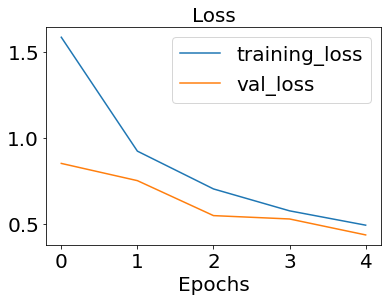

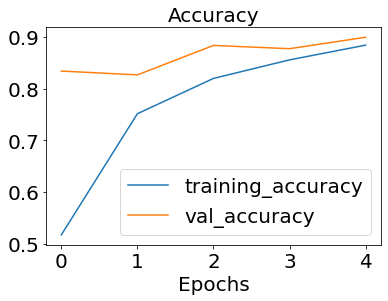

In [ ]:
#Check our loss curves 
plot_loss_curves(model_history)

In [ ]:
prediction = model.predict(data_valid)

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[tf.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(prediction[0])
pred_label

'Common Chickweed'

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image/255.)
    labels.append(class_names[tf.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.35137388, 0.28679055, 0.19199698],
         [0.3248947 , 0.24456954, 0.15226237],
         [0.33883846, 0.2633224 , 0.17756395],
         ...,
         [0.38978344, 0.31045878, 0.23830327],
         [0.3829044 , 0.31109643, 0.22365771],
         [0.41106102, 0.34025735, 0.2461397 ]],
 
        [[0.2894943 , 0.21657763, 0.14458008],
         [0.2533969 , 0.17574008, 0.11066655],
         [0.30395028, 0.21281882, 0.1317852 ],
         ...,
         [0.41870502, 0.35384786, 0.277945  ],
         [0.39616174, 0.3227721 , 0.24593386],
         [0.39641258, 0.2982173 , 0.20762005]],
 
        [[0.2685662 , 0.20122549, 0.14775869],
         [0.24774146, 0.17353803, 0.12093578],
         [0.29816848, 0.18678482, 0.10442517],
         ...,
         [0.44975585, 0.38039312, 0.2857173 ],
         [0.38860676, 0.29879463, 0.18721373],
         [0.38269475, 0.25525334, 0.15418582]],
 
        ...,
 
        [[0.37019473, 0.29259536, 0.20692402],
         [0.3069853 , 0.22112343, 0.13890

In [ ]:
import numpy as np
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

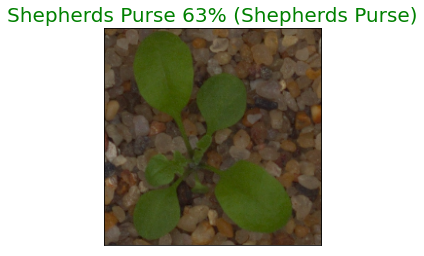

In [ ]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=prediction,
          labels=val_labels,
          images=val_images,n=33)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = np.array(class_names)[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

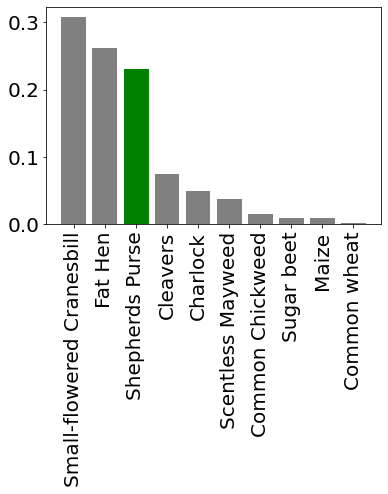

In [ ]:
plot_pred_conf(prediction_probabilities=prediction,
               labels=val_labels,
               n=1)

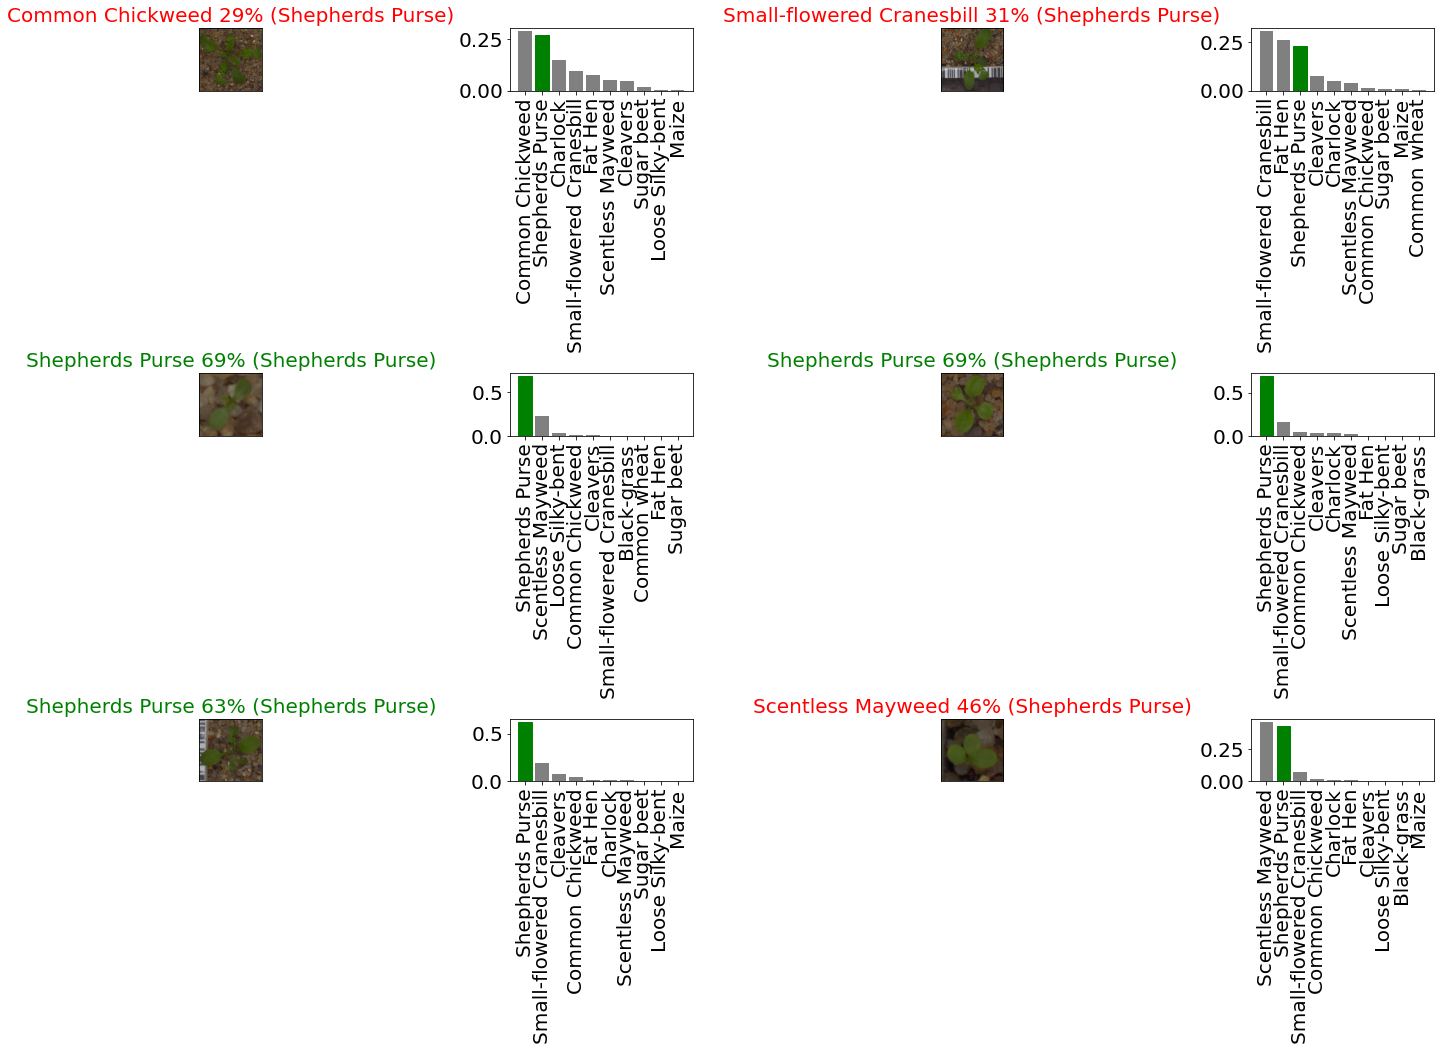

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=prediction,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_path,
                                                                 label_mode="categorical", 
                                                                 shuffle=True,
                                                                 image_size=(224,224),
                                                                batch_size = 32)

Found 4750 files belonging to 12 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(include_top= False,weights='imagenet')

base_model.trainable = False 

inputs = tf.keras.layers.Input(shape=(224,224,3), name='Input_Layer') 

x = base_model(inputs) 

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(), 
             metrics=['accuracy']) 

model_history = model.fit(train_data, 
                          steps_per_epoch=len(train_data),
                         epochs=10
                         )

Epoch 1/10
119/119 [==============================] - 75s 515ms/step - loss: 1.5246 - accuracy: 0.5318
Epoch 2/10
119/119 [==============================] - 43s 344ms/step - loss: 0.9040 - accuracy: 0.7547
Epoch 3/10
119/119 [==============================] - 43s 342ms/step - loss: 0.6902 - accuracy: 0.8258
Epoch 4/10
119/119 [==============================] - 42s 335ms/step - loss: 0.5702 - accuracy: 0.8613
Epoch 5/10
119/119 [==============================] - 42s 332ms/step - loss: 0.4872 - accuracy: 0.8871
Epoch 6/10
119/119 [==============================] - 42s 333ms/step - loss: 0.4294 - accuracy: 0.9016
Epoch 7/10
119/119 [==============================] - 42s 332ms/step - loss: 0.3851 - accuracy: 0.9126
Epoch 8/10
119/119 [==============================] - 42s 333ms/step - loss: 0.3492 - accuracy: 0.9213
Epoch 9/10
119/119 [==============================] - 42s 330ms/step - loss: 0.3186 - accuracy: 0.9292
Epoch 10/10
119/119 [==============================] - 43s 338ms/step - l

In [ ]:
#Prepare the Test data using Tensorflow Image Generator

datagen = ImageDataGenerator()
gen = datagen.flow_from_directory(test_path ,shuffle =False,batch_size=100,
                              target_size = (224,224),classes = ['test'])

Found 794 images belonging to 1 classes.


In [ ]:
prediction = model.predict(gen)
prediction.shape

(794, 12)

In [ ]:
class_names[tf.argmax(prediction[2])]

'Sugar beet'

In [ ]:
#Read sample submission file 
sample_submission = pd.read_csv(abspath_curr + '/sample_submission.csv')
sample_submission.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [ ]:
len(sample_submission)

In [ ]:
#Prepare prediction results
predict_class = []
for pred in prediction: 
    predict_class.append(class_names[tf.argmax(pred)])

predict_class[:10]

['Small-flowered Cranesbill',
 'Fat Hen',
 'Sugar beet',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Fat Hen',
 'Loose Silky-bent',
 'Loose Silky-bent']

In [ ]:
submission = pd.DataFrame({'file':sample_submission['file'],'species':predict_class})
submission.head()

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [ ]:
submission.to_csv(abspath_curr + '/submission.csv', index=False)